<a href="https://colab.research.google.com/github/hi-yuanxu/ManiSkill/blob/main/examples/tutorials/1_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ManiSkill Quick Start + Feature Showcase (BETA)

![](https://github.com/haosulab/ManiSkill/blob/main/figures/teaser.jpg?raw=true)

[ManiSkill](https://github.com/haosulab/ManiSkill) is a feature-rich, user-friendly GPU-accelerated robotics benchmark built on top of [SAPIEN](https://github.com/haosulab/sapien) that is quick and easy to install. ManiSkill is designed to provide accessible support for a wide array of applications from robot learning, learning from demonstrations, sim2real/real2sim, and more. See our [paper on ManiSkill3](https://arxiv.org/abs/2410.00425), the latest iteration of the open-source ManiSkill project, for more details. The teaser image above shows several environments rendered with in ManiSkill, with scene datasets sourced from AI2-THOR and ReplicaCAD.


This notebook serves as a go to place to experiment with several core features that ManiSkill offers without diving too deep into the technical details and excludes those that can't run on Google Colab (such as ray-tracing for photo-realistic rendering). For more technical details on how to build with ManiSkill, see our documentation: [https://maniskill.readthedocs.io/en/latest/user_guide/index.html](https://maniskill.readthedocs.io/en/latest/user_guide/index.html)


This notebooks covers:
1. How to run environments/tasks, modify them, record them, and teleoperate them. (GPU parallelized rendering of RGB-D data achieves 3000+ FPS on even Google Colab's free tier!)
2. Some simple state/visual based RL code/workflows leveraging the GPU accelreated simulator. Solve robotics tasks in minutes instead of hours/days!
3. Working with demonstration/offline data, how to load and replay and convert them
4. Heterogeneous Parallel Simulation. Showcasing simulating tasks where the number of objects or the articulations are completely different between each scene
5. Playing with more robots not included out of the box.
6. Running motion planning solutions to solve tasks.

There are also several [tutorials on our docs](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/) that cover details such as how to build custom tasks or how to add your own robots.

If you click the table of contents tab on the left, each major section can be run independently of the others so feel free to skip to whatever features you are interested in.


**NOTE:**
This project currently is in a **beta release**, so not all features have been added in yet and there may be some bugs. If you find any bugs or have any feature requests please post them to our [GitHub issues](https://github.com/haosulab/ManiSkill/issues/) or discuss about them on [GitHub discussions](https://github.com/haosulab/ManiSkill/discussions/). We also have a [Discord Server](https://discord.gg/x8yUZe5AdN) through which we make announcements and discuss about ManiSkill.


# Setup Code

To begin, prepare the colab environment by switching to a GPU environment (Runtime -> Change Runtime Type)

Then click the play button below. This will install all dependencies for the future code. ManiSkill only requires two pip packages (`maniskill` and `torch`) and setting up Vulkan. For those setting up their code locally you can check our [installation docs](https://maniskill.readthedocs.io/en/latest/user_guide/getting_started/installation.html)

In [2]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill tyro

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libvulkan-dev is already the newest version (1.3.204.1-2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.28.1
    Uninstalling gymnasium-0.28.1:
      Successfully uninstalled gymnasium-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [3]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

#1 Running the Environments (CPU/GPU)


ManiSkill follows the [OpenAI Gym / Gymnasium API](https://gymnasium.farama.org/) making it compatible with a wide range of libraries like those in RL. It is also designed to make task building flexible, simple, and pythonic. We provide a [tutorial on how to build custom tasks](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks/intro.html) on our documentation.


## 1.1 CPU Sim
During CPU simulation this API is followed completely and you can create an environment like so below.

Here we showcase the PegInsertionSide-v1 environment and how to run it. There are many other built-in environments documented at https://maniskill.readthedocs.io/en/latest/tasks/index.html

In [4]:
# 安装特定版本组合
!pip uninstall numpy -y
!pip install numpy==1.24.4  # 根据mani_skill文档选择兼容版本
!pip install gymnasium==0.28.1  # 检查mani_skill所需的gym版本
!pip install mani_skill

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is in

  Using cached gymnasium-0.28.1-py3-none-any.whl.metadata (9.2 kB)
Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mani-skill 3.0.0b20 requires gymnasium==0.29.1, but you have gymnasium 0.28.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.28.1 which is incompatible.
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.28.1
    Uninstalling gymnasium-0.28.1:
      Successfully uninstalled gymnasium-0.28.1
ERROR: pip's dependency resolver does not curre

In [1]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import time
env = gym.make("PegInsertionSide-v1")
obs, _ = env.reset(seed=0)
env.unwrapped.print_sim_details() # print verbose details about the configuration
done = False
start_time = time.time()
while not done:
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
N = info["elapsed_steps"].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PegInsertionSide-v1, 1 parallel environments, sim_backend=physx_cpu
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128), RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (1, 43), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 100 / 1.311469316482544 = 76.25035427302811


In [14]:
!pip install --upgrade gymnasium



  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mani-skill 3.0.0b20 requires gymnasium==0.29.1, but you have gymnasium 1.1.1 which is incompatible.


You may also observe that all the data returned is a batched torch.Tensor. Generally everything inside ManiSkill is kept as batched torch tensors if possible, make it easy to support both CPU and GPU simulation. To have the expected gymnasium behavior (unbatched, numpy arrays) you can do the following

In [2]:
from mani_skill.utils.wrappers import CPUGymWrapper
env = gym.make("PegInsertionSide-v1")
env = CPUGymWrapper(env)
obs, _ = env.reset() # obs is numpy and unbatched
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (43,)


To then render what it looks like you can use either `env.render`. Note that above we set the render_mode to be `"rgb_array"`, which is following the Gymnasium API and configures what `env.render` returns.

If the render_mode is set to `"sensors"` then it returns a rgb array showing the actual visual data you would receive if you choose a visual based observation mode.

If the render mode is `all` then this combines `"rgb_array"` and `"sensors"` modes.

If the render mode is set to `"human"` (the default) then it opens a GUI viewer that you can use to interact with the environment (requires a display).

The example below shows a very simple render of a simple environment. ManiSkill supports all kinds of rendering options when building environments (modifying lighting, shadows, textures, environment maps etc.).

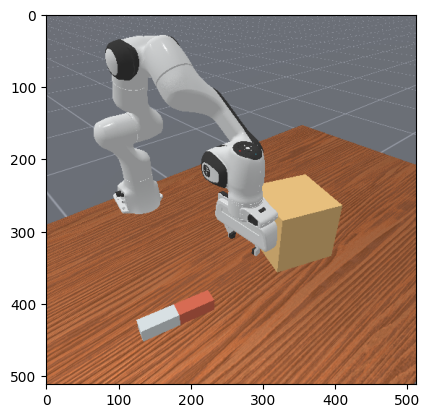

In [4]:
import matplotlib.pyplot as plt
env = gym.make("PegInsertionSide-v1", render_mode="rgb_array")
env.reset()
plt.imshow(env.render()[0].cpu().numpy()) # we take [0].numpy() as everything is a batched tensor

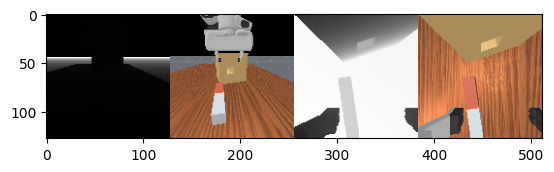

In [5]:
import matplotlib.pyplot as plt
env = gym.make("PegInsertionSide-v1", render_mode="sensors")
env.reset()
plt.imshow(env.render()[0].cpu().numpy()) # we take [0].numpy() as everything is a batched tensor

## 1.2 GPU (State-only)

Running the GPU simulation is as easy as setting the `num_envs` argument to a number > 1. On Colab's free tier (T4 GPU) you should be able to run up to 2048 parallel environments of the PickCube-v1 task and achieve around 20,000 FPS. You can also run multiple environments, which can be useful for ML workflows by keeping a training and evaluation environment. Note that simulation FPS is heavily dependent on the simulation and control frequencies, the objects in the scene, etc., so your FPS for your own environments can vary in a wide range.

During GPU parallelized simulation, nearly everything in ManiSkill is batched and a torch tensor by default. Moreover, due to how ManiSkill is structured with the underlying SAPIEN engine most tasks created are always simulatable on the CPU and GPU.

*Note that currently you cannot run a CPU simulation followed by a GPU simulation and vice versa. If you ran the cell above simply restart the notebook (shortcut is `ctrl+M+.`)*

*Note that there is currently a bug that only appears on Colab where GPU resources do not get released after closing GPU sim environments. The fix for now is to simply restart the notebook*

In [1]:
### Make sure to restart the notebook if you already ran a CPU sim!! ###
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 2048 # you can go up to 4096 on better GPUs
env = gym.make("PickCube-v1", num_envs=num_envs)
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 2048 parallel environments, sim_backend=physx_cuda
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (2048, 42), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 102400 / 3.8670177459716797 = 26480.354300590254


## 1.3 GPU (State+Visual)

A key feature of ManiSkill and SAPIEN is the ability to render in parallel, allowing for extremely high FPS for visual rendering, which can be incredibly useful for computer vision workflows and visual RL. On Colab's free tier (T4 GPU) you should be able to run 512 parallel environments of the PickCube-v1 task and achieve around 3500FPS when sampling random actions

In [2]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgbd")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 512 parallel environments, sim_backend=physx_cuda
obs_mode=rgbd, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (512, 9), float32), 'qvel': Box(-inf, inf, (512, 9), float32)), 'extra': Dict('is_grasped': Box(False, True, (512,), bool), 'tcp_pose': Box(-inf, inf, (512, 7), float32), 'goal_pos': Box(-inf, inf, (512, 3), float32)), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (512, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (512, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (512, 3, 3), float32))), 'sensor_data': Dict('base_camera': Dict('rgb': Box(0, 255, (512, 128, 128, 3), uint8), 'depth': Box(-32768, 32767, (512, 128, 128, 1), int16))))
(single) action space: Box(-1.0, 1.0, (8,), float32)
# ----------------------------------------

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['rgb', 'depth'])
torch.Size([512, 128, 128, 3])


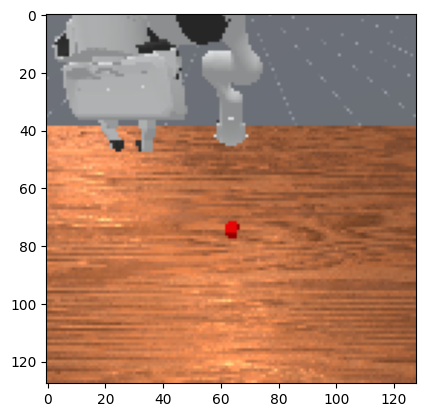

In [3]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())

## 1.4 Changing the Environment's Observations and Controllers

ManiSkill flexibly supports several **observation modes (state and visual)** as well as changing the **controller** used to control the robots in the simulation. Furthermore the reward mode and even the robot itself can flexibly be changed. Documentation on observations and controllers can be found [here](https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html).

Controller design is important when it comes to problems of sim2real transfer so ManiSkill has built-in support for robot implementations to have multiple controllers.

We will demonstrate these on the GPU sim.

In [4]:
# Import required packages
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill.envs
import matplotlib.pyplot as plt

Action Space: Box(-1.0, 1.0, (4, 7), float32)


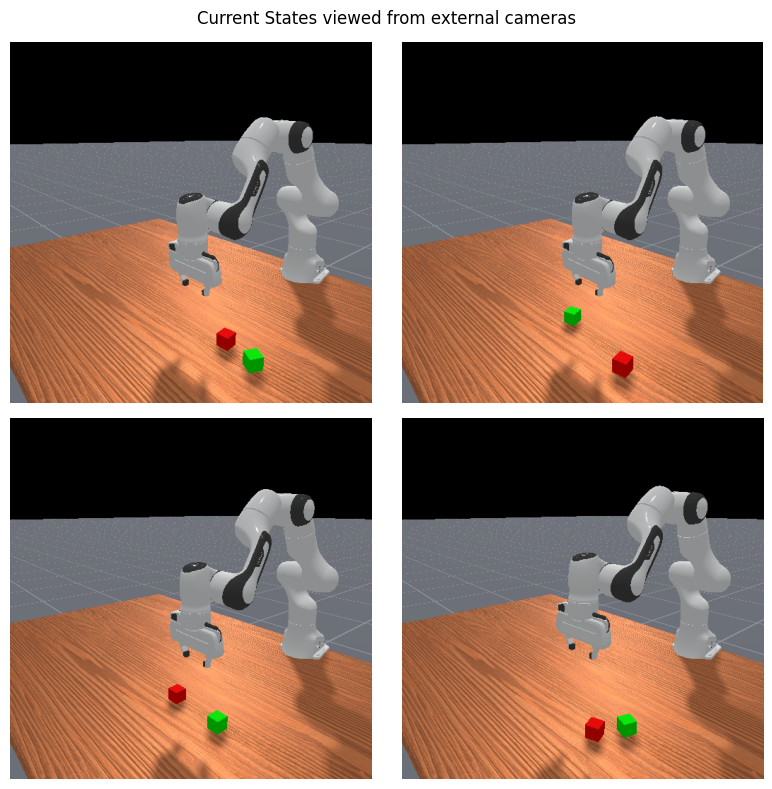

In [15]:
#@markdown Run this cell to display the action space of the chosen controller as well as the current view of the environment
# Can be any env_id from the list of Rigid-Body envs: https://maniskill.readthedocs.io/en/latest/tasks/index.html
env_id = "StackCube-v1" #@param ['PickCube-v1', 'PegInsertionSide-v1', 'StackCube-v1']

# choose an observation type and space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/observation.html for details
obs_mode = "pointcloud" #@param can be one of ['pointcloud', 'rgb+depth+segmentation', 'state_dict', 'state']

# choose a controller type / action space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html for a full list
control_mode = "pd_ee_delta_pose" #@param can be one of ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param can be one of ['sparse', 'dense']

robot_uids = "panda" #@param can be one of ['panda', 'fetch']

# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               num_envs=4,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               robot_uids=robot_uids,
               enable_shadow=True # this makes the default lighting cast shadows
               )
obs, _ = env.reset()
print("Action Space:", env.action_space)

# take a look at the current state of the 4 parallel environments we created
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
rgbs = env.render_rgb_array() # this is a easy way to get the rgb array without having to set render_mode
for i, ax in enumerate(axs.flatten()):
    ax.imshow(rgbs[i].cpu().numpy())
    ax.axis("off")
plt.suptitle("Current States viewed from external cameras")
fig.tight_layout()
env.close()

In [12]:
# some visualization functions for different observation modes
def show_camera_view(obs_camera, title, env_id=0):
    plt.figure()
    rgb, depth = obs_camera['rgb'], obs_camera['depth']
    plt.subplot(1,3,1)
    plt.title(f"{title} - RGB")
    plt.imshow(rgb[env_id].cpu().numpy())
    plt.subplot(1,3,2)
    plt.title(f"{title} - Depth")
    plt.imshow(depth[..., 0][env_id].cpu().numpy(), cmap="gray")
    plt.subplot(1,3,3)
    plt.title(f"{title} - Segmentation")
    plt.imshow(obs_camera["segmentation"][..., 0][env_id].cpu().numpy())

def show_pointcloud(obs, env_id=0):
    import trimesh
    v = obs['pointcloud']['xyzw'][env_id, ..., :3].cpu().numpy()
    cam2world = obs["sensor_param"]["base_camera"]["cam2world_gl"][env_id].cpu().numpy()
    cam2world = cam2world
    camera = trimesh.scene.Camera("camera", (1024, 1024), fov=(np.rad2deg(np.pi/2), np.rad2deg(np.pi/2)))
    s = trimesh.Scene([trimesh.points.PointCloud(v, obs['pointcloud']['rgb'][env_id].cpu().numpy())], camera=camera, camera_transform=cam2world)
    return s.show()

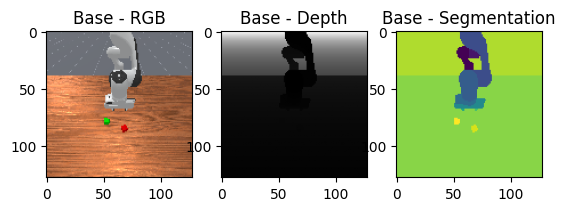

In [13]:
#@markdown Display the RGBD+Segmentation observation. Make sure you are using `obs_mode="rgbd"`
show_camera_view(obs['sensor_data']['base_camera'], "Base")

In [16]:
#@markdown Display one of the Pointcloud observations. Make sure you are using `obs_mode="pointcloud"`
show_pointcloud(obs)

## 1.5 Interactive Viewer and Recording videos

To create a replay video of what happened in an episode, we can use the `RecordEpisode` environment wrapper shown below, and specify what we want to record.

`RecordEpisode` will always use what the `render_mode` specified at environment creation is, and in the code below we use "rgb_array" as shown earlier. "rgb_array" corresponds with RGB cameras and will render what they show. There is also the "sensors" render mode which shows a visualization of all sensor data (e.g. RGB and depth) together.

ManiSkill has an interactive viewer, available if you run locally on a machine with a GUI. You can render the current state with `env.render_human
()` which will bring up a viewer. The script below will show the interactive viewer if it detects that it is not running in Colab.

In [19]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows which make the default lighting cast shadows
env = gym.make("PickCube-v1", num_envs=4, render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2025-05-09 09:10:20,209 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/100 [00:00<?, ?it/s]

## 1.6 Teleoperation

To interactively control the robot, we plan to open-source a number of different tools to collect data, which include using VR systems, computer camera based systems, and more.


We currently provide a simple GUI-based tele-operation tool that lets you move the robot's end-effector around, toggle grasping, and make it follow your commands to solve tasks. More details about it can be found [here](https://maniskill.readthedocs.io/en/latest/user_guide/data_collection/teleoperation.html#click-drag-system). A video demonstrating how it works is shown below for the `StackCube-v1` task.

In [20]:
!python -m mani_skill.examples.teleoperation.interactive_panda -e "StackCube-v1"

2025-05-09 09:12:19,134 - mani_skill  - WARNING - mani_skill is not installed with git.
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_human to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_human` for environment variables or `env.get_wrapper_attr('render_human')` that will search the reminding wrappers.
  logger.warn(
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/mani_skill/examples/teleoperation/interactive_panda.py", line 251, in <module>
    main(parse_args())
  File "/usr/local/lib/python3.11/dist-packages/mani_skill/examples/teleoperation/interactive_panda.py", line 65, in main
    code = solve(env, debug=False, vis=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
%%html
<video controls width=800>
<source src="https://github.com/haosulab/ManiSkill/raw/main/docs/source/_static/videos/teleop-stackcube-demo.mp4">
</video>

#2 Reinforcement Learning

ManiSkill provides some simple baselines for reinforcement learning that can be run straight in google colab. The demo below solves some of the tasks from state and visual inputs and demonstrate just how quickly tasks can be solved with our GPU parallelized state/visual simulation. Documentation on all our baselines as well as how to evaluate models correctly in Maniskill can be found on our [RL documentation page](https://maniskill.readthedocs.io/en/latest/user_guide/reinforcement_learning/)

As RL code can be quite long, we refer users to read the code at https://github.com/haosulab/ManiSkill/tree/main/examples/baselines/ppo, an implementation of Proximal Policy Optimization adapted from [CleanRL](https://github.com/vwxyzjn/cleanrl/). In the future we will add support for other commonly used libraries.

To get started first download the RL code as done below and import some packages

In [21]:
from IPython.display import Video

In [22]:
!wget https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo.py -O ppo.py
!wget https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo_rgb.py -O ppo_rgb.py

--2025-05-09 09:14:37--  https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22982 (22K) [text/plain]
Saving to: ‘ppo.py’

ppo.py              100%[===================>]  22.44K  --.-KB/s    in 0.002s  

2025-05-09 09:14:37 (13.7 MB/s) - ‘ppo.py’ saved [22982/22982]

--2025-05-09 09:14:37--  https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo_rgb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28267 (28K) [text/p

The cell below opens tensorboard on colab so you can watch training metrics.

In [2]:
%load_ext tensorboard
%tensorboard --logdir runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/default.py", line 39, in <module>
    from tensorboard.plugins.hparams import hparams_plugin
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/plugins/hparams/hparams_plugin.py", line 30, in <module>
    from tensorboard.plugins.hparams import backend_context
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/plugins/hparams/backend_context.py", line 26, in <module>
    from tensorboard.plugins.hparams import metadata
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/plugins/hparams/metadata.py", line 32, in <module>
    NULL_TENSOR = tensor_util.make_tensor_proto(
     

### 2.1 State Based RL

The cell below runs the actual training code for state based RL, and should solve the task in about 2 minutes on Google Colab (and normally can solve it under a minute if using a better GPU). You can open the folder on the files tab on the left under runs > state-pushcube > videos > n.mp4 to see the evaluation videos. Notably thanks to parallel rendering the code can easily just generate multiple videos together at once in parallel during evaluation.

See https://github.com/haosulab/ManiSkill/tree/main/examples/baselines/ppo for more example tuned scripts. Note that not all tasks built in ManiSkill are solvable with RL out of the box yet (they are meant to be a range of easy to extremely difficult tasks).

In [1]:
pip install tensorboard==2.15.0 --force-reinstall

  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached grpcio-1.71.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached google_auth-2.40.1-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
 

In [1]:
!python ppo.py --env_id="PushCube-v1" --exp-name="state-pushcube" \
  --num_envs=1024 --update_epochs=8 --num_minibatches=32 \
  --total_timesteps=600_000 --eval_freq=8 --num-steps=20

2025-05-09 09:21:54.817021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746782514.836907   39978 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746782514.843072   39978 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 09:21:54.863572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Saving eval videos to runs/state-pushcube/videos
Running training
####
args.num_iterations=29 args.num_envs=1024 args

In [4]:
from IPython.display import Video
Video("runs/state-pushcube/videos/3.mp4", embed=True, width=1024) # Watch a replay during training evaluation

### 2.2 Visual Based RL

The cell below runs visual based RL (using only RGB data), and should solve the task in about 5 minutes on Google Colab (and normally can solve it under a minute if using a better GPU). You can open the folder on the files tab on the left under runs > rgb-pushcube > videos > n.mp4 to see the evaluation videos.

See https://github.com/haosulab/ManiSkill/tree/main/examples/baselines/ppo for more example tuned scripts. Note that not all tasks built in ManiSkill are solvable with visual RL out of the box yet (they are meant to be a range of easy to extremely difficult tasks).

In [5]:
!python ppo_rgb.py --env_id="PushCube-v1" --exp-name="rgb-pushcube" \
  --num_envs=256 --update_epochs=8 --num_minibatches=16 \
  --total_timesteps=250_000 --eval_freq=10 --num-steps=20

2025-05-09 09:29:15.200097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746782955.221600   42349 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746782955.227965   42349 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 09:29:15.248444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Saving eval videos to runs/rgb-pushcube/videos
Running training
####
args.num_iterations=48 args.num_envs=256 args.nu

We can generate more evaluation trajectories as done below and then replay them with a trajectory replaying tool to show what the actual visual inputs look like and how the trained RL agent is using it to solve the task. The cell below will save a .h5 file to the `test_videos` folder of your experiment

In [6]:
!python ppo_rgb.py --env_id="PushCube-v1" \
  --evaluate --checkpoint=runs/rgb-pushcube/ckpt_41.pt \
  --num_eval_envs=1 --num-eval-steps=100

2025-05-09 09:37:03.194569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746783423.214666   48668 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746783423.220977   48668 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 09:37:03.242231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Saving eval videos to runs/rgb-pushcube/test_videos
2025-05-09 09:37:10,397 - mani_skill  - WARNING - mani_skill is n

The cell below uses the replay tool to then re-run the trajectories we generated above and save a video using the sensors render mode. The replay tool is documented in detail [here](https://maniskill.readthedocs.io/en/latest/user_guide/datasets/replay.html)

In [7]:
!python -m mani_skill.trajectory.replay_trajectory \
  --traj-path=/content/runs/rgb-pushcube/test_videos/trajectory.h5 --use-env-states \
  --render-mode="sensors" --save-video --allow-failure

2025-05-09 09:37:51,903 - mani_skill  - WARNING - Warning: Using different backend (None) than the original used to collect the trajectory data (physx_cuda). This may cause replay failures due to differences in simulation/physics engine backend. Use the same backend by passing -b physx_cuda or replay by environment states by passing --use-env-states instead.
  0% 0/2 [00:00<?, ?step/s]2025-05-09 09:37:54,357 - mani_skill  - WARNING - Reset kwargs includes options, which are not supported in GPU sim replay and will be ignored.
  0% 0/2 [00:04<?, ?step/s]
  0% 0/2 [00:06<?, ?step/s]
Replayed 2 episodes, 0/2=0.00% demos saved


In [8]:
Video("runs/rgb-pushcube/test_videos/0.mp4", embed=True, width=256) # Watch our replay from the camera perspective we trained on

#3 Demonstration Data

Managing and collecting/generating trajectory data is supported in ManiSkill. This section will cover both how to load existing trajectory data as well as tools helpful for getting more data.

In [9]:
from IPython.display import Video

### 3.1 Download and load

We provide a simple command line tool to download demos. Specify an output folder and environment ID and it will download the appropriate demonstrations open sourced at https://huggingface.co/datasets/haosulab/ManiSkill. There are various tele-operated/motionplanning/policy-generated demonstrations. Furthermore when downloaded, there will be sample videos of the demonstration that show what the demonstration looks like. We first download the demonstration dataset below. By default it saves to `~/.maniskill/demos`.

In [10]:
!python -m mani_skill.utils.download_demo "PegInsertionSide-v1" -o demos

29.5Mit [00:00, 52.9Mit/s]              


In [11]:
Video("demos/PegInsertionSide-v1/motionplanning/sample.mp4", embed=True, width=512)

To load the demonstration dataset, you can follow the dataset code at https://github.com/haosulab/ManiSkill/blob/main/mani_skill/trajectory/dataset.py which is a simple PyTorch dataset style approach that should be able to load just about any ManiSkill dataset.



In [12]:
from mani_skill.trajectory.dataset import ManiSkillTrajectoryDataset
dataset = ManiSkillTrajectoryDataset(dataset_file="demos/PegInsertionSide-v1/motionplanning/trajectory.h5")
data = dataset[150]
for k, v in data.items():
    print(k, v)

100%|██████████| 1000/1000 [00:02<00:00, 356.56it/s]

obs {}
action tensor([ 0.1283,  0.3398, -0.0656, -2.2988,  0.0596,  2.6386, -0.4462, -1.0000])
terminated False
truncated True
reward 7.424719
success False


Alternatively you can load the raw data yourself via h5py and a load_json utility:

In [13]:
import h5py
from mani_skill.utils.io_utils import load_json

# Load the trajectory data from the .h5 file. Demonstrations are versioned and thus saved to "demos/<version>/..."
traj_path = f"demos/PegInsertionSide-v1/motionplanning/trajectory.h5"
# You can also replace the above path with the trajectory you just recorded (./tmp/trajectory.h5)
h5_file = h5py.File(traj_path, "r")

# Load associated json
json_path = traj_path.replace(".h5", ".json")
json_data = load_json(json_path)

episodes = json_data["episodes"] # meta data of each episode
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]

print("env_id:", env_id)
print("env_kwargs:", env_kwargs)
print("#episodes:", len(episodes))
print("Dataset source:", json_data["source_type"])
print("Dataset source description:", json_data["source_desc"])

env_id: PegInsertionSide-v1
env_kwargs: {'obs_mode': 'none', 'control_mode': 'pd_joint_pos', 'render_mode': 'rgb_array', 'reward_mode': 'dense', 'sensor_configs': {'shader_pack': 'default'}, 'human_render_camera_configs': {'shader_pack': 'default'}, 'viewer_camera_configs': {'shader_pack': 'default'}, 'sim_backend': 'auto'}
#episodes: 1000
Dataset source: motionplanning
Dataset source description: official motion planning solution from ManiSkill contributors


The trajectory of each episode is stored under the `traj_{episode_id}` key in the HDF5 file. `episode_id` usually ranges from 0 to `len(episodes) - 1`.
`episode_id` and other meta information of episdoes are stored under the `episodes` key in the JSON file.

The raw trajectory always contains the keys: `actions`, `env_states`, `terminated`, and `truncated`. The trajectory may optionally include `success`, `fail` and `reward`. Success and fail are included if the task the trajectory is from has success/failure conditions in its evaluation.

In [14]:
traj_id = "traj_0"
traj_h5 = h5_file[traj_id]
def print_h5py_structure(traj_h5, prefix=""):
    for key in traj_h5:
        if isinstance(traj_h5[key], h5py.Group):
            print_h5py_structure(traj_h5[key], prefix=prefix + "/" + key)
        else:
            print(prefix + "/" + key, traj_h5[key].shape, traj_h5[key].dtype)

print_h5py_structure(traj_h5)

/actions (178, 8) float32
/terminated (178,) bool
/truncated (178,) bool
/success (178,) bool
/env_states/actors/table-workspace (179, 13) float32
/env_states/actors/peg (179, 13) float32
/env_states/actors/box_with_hole (179, 13) float32
/env_states/articulations/panda_wristcam (179, 31) float32
/rewards (178,) float32


Some data are more nested such as `env_states`, which is a nested dictionary. In order to be efficient, it is stored as a nested dictionary of arrays. We provide some simple tools to convert it to a list of dictionaries or to just simply select a single element below. These can be useful if you wish to e.g. set environment state (demonstrated in section 3.2)

In [15]:
from mani_skill.trajectory.utils import index_dict, dict_to_list_of_dicts
index_dict(traj_h5["env_states"], 23) # select the 23rd element of all values

{'actors': {'table-workspace': array([-0.12     ,  0.       , -0.9196429,  0.7071068,  0.       ,
          0.       ,  0.7071068,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ], dtype=float32),
  'peg': array([ 2.29395665e-02, -1.85696363e-01,  1.52592035e-02,  5.32645464e-01,
          2.31013973e-06,  3.44357477e-06,  8.46338511e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00], dtype=float32),
  'box_with_hole': array([ 1.1903636e-02,  2.8850654e-01,  1.0243980e-01,  8.1875265e-01,
          0.0000000e+00, -3.7252903e-09,  5.7414639e-01,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00], dtype=float32)},
 'articulations': {'panda_wristcam': array([-6.1500001e-01,  7.2759576e-11, -1.4901161e-08,  1.0000001e+00,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.00

In [16]:
env_states = dict_to_list_of_dicts(traj_h5["env_states"]) # convert to a list of dictionaries
env_states[23]

{'actors': {'table-workspace': array([-0.12     ,  0.       , -0.9196429,  0.7071068,  0.       ,
          0.       ,  0.7071068,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ], dtype=float32),
  'peg': array([ 2.29395665e-02, -1.85696363e-01,  1.52592035e-02,  5.32645464e-01,
          2.31013973e-06,  3.44357477e-06,  8.46338511e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00], dtype=float32),
  'box_with_hole': array([ 1.1903636e-02,  2.8850654e-01,  1.0243980e-01,  8.1875265e-01,
          0.0000000e+00, -3.7252903e-09,  5.7414639e-01,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00], dtype=float32)},
 'articulations': {'panda_wristcam': array([-6.1500001e-01,  7.2759576e-11, -1.4901161e-08,  1.0000001e+00,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.00

**Note that the raw trajectories often do not include actual observations.** We store both actions and environment states, which can be used to replay trajectories and generate desired observations (states, RGBD images, point cloud etc.). Please see the following sections for how to replay and convert demonstrations to your desired observation and action spaces.

### 3.2 Replay demonstrations

We provide [advanced demonstration/trajectory tools](https://maniskill.readthedocs.io/en/latest/user_guide/datasets/replay.html) that enable you to replay demos, modify observations/action spaces and more. The code below shows a minimal way to replay demonstrations without the tool.  

To replay the trajectory of an episode, you need to first create an environment given the environment initialization keyword arguments stored in the JSON file. Additionally, you need to reset the environment with the same seed and other keyword arguments of the episode recorded in the JSON file. Then, the trajectory can be replayed by actions or environment states stored in the HDF5 file.

In [23]:
from mani_skill.utils.visualization.misc import images_to_video
import gymnasium as gym
import mani_skill.envs
from tqdm.notebook import tqdm
def replay(episode_idx, h5_file, json_data, render_mode="cameras", fps=20):
    episodes = json_data["episodes"]
    ep = episodes[episode_idx]
    # episode_id should be the same as episode_idx, unless specified otherwise
    episode_id = ep["episode_id"]
    traj = h5_file[f"traj_{episode_id}"]
    env_states = dict_to_list_of_dicts(traj["env_states"])

    # Create the environment
    env_kwargs = json_data["env_info"]["env_kwargs"]
    env = gym.make(json_data["env_info"]["env_id"], **env_kwargs)
    print(env_kwargs)
    # Reset the environment
    reset_kwargs = ep["reset_kwargs"].copy()
    reset_kwargs["seed"] = ep["episode_seed"]
    env.reset(**reset_kwargs)

    frames = [env.render_rgb_array().cpu()[0].numpy()]
    for i in tqdm(range(len(traj["actions"]))):
        action = traj["actions"][i]
        obs, reward, terminated, truncated, info = env.step(action)
        env.set_state_dict(env_states[i])
        frames.append(env.render_rgb_array().cpu()[0].numpy())

    env.close()
    del env
    images_to_video(frames, output_dir=".", video_name="replay", fps=30, )

In [24]:
#@markdown Choose an episode ID here and run this cell to watch a replay of a expert demo. Note that this can be a little slow as this code generates a video. To run faster we recommend watching on a machine with a GUI and running only the replay function.

episode_idx = 4 #@param {type:"integer"}
replay(episode_idx, h5_file, json_data)
Video("./replay.mp4", embed=True)

{'obs_mode': 'none', 'control_mode': 'pd_joint_pos', 'render_mode': 'rgb_array', 'reward_mode': 'dense', 'sensor_configs': {'shader_pack': 'default'}, 'human_render_camera_configs': {'shader_pack': 'default'}, 'viewer_camera_configs': {'shader_pack': 'default'}, 'sim_backend': 'auto'}


/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_rgb_array to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_rgb_array` for environment variables or `env.get_wrapper_attr('render_rgb_array')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/189 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_state_dict to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_state_dict` for environment variables or `env.get_wrapper_attr('set_state_dict')` that will search the reminding wrappers.
  logger.warn(


Video created: ./replay.mp4


100%|██████████| 190/190 [00:01<00:00, 138.62it/s]


### 3.3 Convert demonstrations across observation/action spaces

The demonstration dataset does not include actual observations in order to save space. You can convert trajectories to the desired observation space and action space and specify the number of parallel processes to run to speed this up.

The command below will generate the file `demos/PegInsertionSide-v1/motionplanning/trajectory.rgbd.pd_joint_delta_pos.cpu.h5` and its associated json metadata file. In general, generating trajectories like this will separate them based on the file name, which specifies the observation mode, control mode, and which sim backend is used (CPU or GPU). Furthermore, note that not all trajectories will replay successfully, this can be due to some noise in the simulation or minor deviations caused by controller changes.

In [26]:
!python -m mani_skill.trajectory.replay_trajectory --help

usage: replay_trajectory.py [-h] [OPTIONS]

╭─ options ──────────────────────────────────────────────────────────────────╮
│ -h, --help                                                                 │
│     show this help message and exit                                        │
│ --traj-path STR                                                            │
│     Path to the trajectory .h5 file to replay (required)                   │
│ -b {None}|STR, --sim-backend {None}|STR                                    │
│     Which simulation backend to use. Can be 'physx_cpu', 'physx_gpu'. If   │
│     not specified the backend used is the same as the one used to collect  │
│     the trajectory data. (default: None)                                   │
│ -o {None}|STR, --obs-mode {None}|STR                                       │
│     Target observation mode to record in the trajectory. See               │
│     https://maniskill.readthedocs.io/en/latest/user_guide/concepts/observa │
│     ti

In [27]:
!python -m mani_skill.trajectory.replay_trajectory \
    --traj-path demos/PegInsertionSide-v1/motionplanning/trajectory.h5 --save-traj \
    --obs-mode rgbd -c "pd_joint_delta_pos" --num-envs 1 --count 2 # only generate 2

0step [00:00, ?step/s]2025-05-09 09:59:00,917 - mani_skill  - WARNING - mani_skill is not installed with git.
Replaying traj_0:   0% 0/178 [00:00<?, ?step/s]/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.device to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.device` for environment variables or `env.get_wrapper_attr('device')` that will search the reminding wrappers.
  logger.warn(
Replaying traj_1: 100% 156/156 [00:06<00:00, 24.55step/s]
  0% 0/2 [00:16<?, ?step/s]
Replayed 2 episodes, 2/2=100.00% demos saved


We can load the converted dataset and now look at the new RGBD data added into it

100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


len(dataset) 334


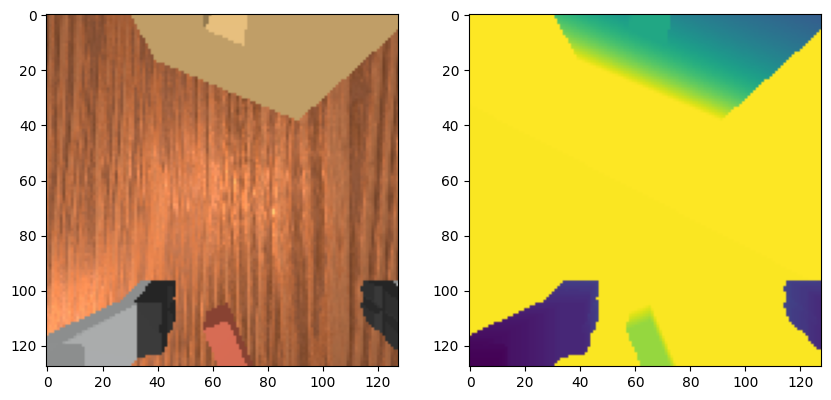

In [31]:
from mani_skill.trajectory.dataset import ManiSkillTrajectoryDataset
import matplotlib.pyplot as plt
dataset = ManiSkillTrajectoryDataset(dataset_file="demos/PegInsertionSide-v1/motionplanning/trajectory.rgbd.pd_joint_delta_pos.physx_cpu.h5")
print('len(dataset)',len(dataset))
data = dataset[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(data["obs"]["sensor_data"]["hand_camera"]["rgb"])
axs[1].imshow(data["obs"]["sensor_data"]["hand_camera"]["depth"])

#4 Heterogeneous Parallel Simulation

ManiSkill supports simulating tasks where each parallel environment may have a different number of objects and/or articulations with different degrees of freedom.

Assuming you have learned [how to build custom tasks](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks.html) in ManiSkill already, you can checkout [advanced features](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks.html) that enable diverse parallel simulation. ManiSkill was designed to abstract away as much of the GPU memory management code as possible to make task building flexible, simple, and pythonic.


To get started, we will download sets of assets to showcase these features and import necessary packages.

In [1]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video

In [2]:
# asset downloads may vary in speed depending on server
!python -m mani_skill.utils.download_asset -y PickClutterYCB-v1
!python -m mani_skill.utils.download_asset -y partnet_mobility

<frozen runpy>:128: RuntimeWarning: 'mani_skill.utils.download_asset' found in sys.modules after import of package 'mani_skill.utils', but prior to execution of 'mani_skill.utils.download_asset'; this may result in unpredictable behaviour
25.0MiB [00:00, 63.1MiB/s]               
100% 550/550 [00:00<00:00, 915.33it/s]
Asset (ycb) is successfully downloaded to /root/.maniskill/data/assets/mani_skill2_ycb.
15.9MiB [00:00, 65.4MiB/s]               
Asset (pick_clutter_ycb_configs) is successfully downloaded to /root/.maniskill/data/tasks/pick_clutter.
<frozen runpy>:128: RuntimeWarning: 'mani_skill.utils.download_asset' found in sys.modules after import of package 'mani_skill.utils', but prior to execution of 'mani_skill.utils.download_asset'; this may result in unpredictable behaviour
1.36MiB [00:00, 13.0MiB/s]              
100% 157/157 [00:00<00:00, 4503.62it/s]
Asset (partnet_mobility/5020) is successfully downloaded to /root/.maniskill/data/partnet_mobility/dataset/5020.
4.99MiB [00:

## 4.1 Parallel Simulation of Varying Number of Actors

The PickSingleYCB task is about picking up a object from the YCB dataset from a pile of other YCB objects. It is programmed so that each parallel environment has a different number of cluttered objects in the pile with a different target object to pick.

In [3]:
# 重启
# See section 1.5 for more details on how we create environments and save videos
env = gym.make("PickClutterYCB-v1", num_envs=4, render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(env, "./videos", max_steps_per_video=100, save_trajectory=False)

# step through the environment with random actions
obs, _ = env.reset(seed=0)
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
env.close()
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

  0%|          | 0/100 [00:00<?, ?it/s]

## 4.2 Parallel Simulation of Articulations with different DOFs
The OpenCabinetDrawer task is about controlling a mobile manipulation robot (here we use the Fetch robot) to open a random drawer from a random cabinet. Note that each of these cabinets have a different number of joints (e.g. revolute joints that allow for things to swing open and prismatic joints that allow for things to slide open).

What's powerful about diverse parallel simulation in terms of geometry is that now with tools like RL you can train a policy to learn to open every cabinet drawer all at once without needing access to a massive CPU farm. State based RL (with PPO) can solve the entire OpenCabinetDrawer task in about 15-20 minutes. You can try the RL code in section 2 for this particular task.

In [ ]:
env = gym.make("OpenCabinetDrawer-v1", num_envs=4, control_mode="pd_joint_delta_pos", render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(env, "./videos", max_steps_per_video=100, save_trajectory=False)

obs, _ = env.reset(seed=0)
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
env.close()
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

  0%|          | 0/100 [00:00<?, ?it/s]

#5 More Robots

ManiSkill out of the box supports many robots and has tuned most of them so that they can be simulated fast. You can find a full gallery of all of them here: https://maniskill.readthedocs.io/en/latest/robots/index.html

However, some do not have existing tasks built for them and are there for demonstration purposes and others to build with.

To try out an existing robot, you can download it's assets and use robot `keyframes` (an idea borrowed over from Mujoco) to take a look at what the robot looks like.

The code here is similar to the script on our GitHub: https://github.com/haosulab/ManiSkill/blob/main/mani_skill/examples/demo_robot.py

In [ ]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video

In [ ]:
!python -m mani_skill.utils.download_asset -y "anymal_c"

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'mani_skill.utils.download_asset' found in sys.modules after import of package 'mani_skill.utils', but prior to execution of 'mani_skill.utils.download_asset'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
4.25MiB [00:00, 4.96MiB/s]
100% 55/55 [00:00<00:00, 333.98it/s]
Asset (anymal_c) is successfully downloaded to /root/.maniskill/data/robots/anymal_c.


In [ ]:
env = gym.make(
    "Empty-v1",
    obs_mode="none",
    reward_mode="none",
    enable_shadow=True,
    control_mode="pd_joint_pos", # allows us to easily hold joints mostly in place
    robot_uids="anymal_c",
    render_mode="rgb_array",
)
env = RecordEpisode(env, "./videos", save_trajectory=False)
print(env.agent.keyframes.keys())

dict_keys(['standing'])


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_episode_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_episode_steps` for environment variables or `env.get_wrapper_attr('max_episode_steps')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent` for environment variables or `env.get_wrapper_attr('agent')` that will search the reminding wrappers.
  logger.warn(


For the ANYmal-C robot we can create an empty environment and print out what keyframes are available to set the robot to for visualization. Here there is just the "standing" keyframe which we visualize below by using the pose and qpos values defined in the keyframe object.

In [ ]:
env.reset()
kf = env.agent.keyframes["standing"]
env.agent.robot.set_pose(kf.pose)
env.agent.robot.set_qpos(kf.qpos)

# if running on a GPU environment you have to
# apply the changes to environment state
if env.gpu_sim_enabled:
    env.scene._gpu_apply_all() # applies changes
    env.scene.px.gpu_update_articulation_kinematics() # updates robot link poses necessary to render correctly
    env.scene._gpu_fetch_all() # updates GPU buffers
env.render() # call this to update the rendering
for i in tqdm(range(20)):
    # with pd_joint_pos control we try to get the robot to maintain the same joint
    # positions as the keyframe
    obs, reward, terminated, truncated, info = env.step(kf.qpos)
env.flush_video("example")
Video("./videos/example.mp4", embed=True, width=640) # Watch our replay

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.gpu_sim_enabled to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.gpu_sim_enabled` for environment variables or `env.get_wrapper_attr('gpu_sim_enabled')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

And just for fun you can play around with how you spawn the robot. Turns out this standing configuration is fairly robust so we can drop it from above and see a bit more action with this quadruped.

In [ ]:
import sapien
env.reset()
kf = env.agent.keyframes["standing"]
# drop the robot from 1 meter above ground
env.agent.robot.set_pose(sapien.Pose([0, 0, 1]))
env.agent.robot.set_qpos(kf.qpos)
# if running on a GPU environment you have to
# if running on a GPU environment you have to
# apply the changes to environment state
if env.gpu_sim_enabled:
    env.scene._gpu_apply_all() # applies changes
    env.scene.px.gpu_update_articulation_kinematics() # updates robot link poses necessary to render correctly
    env.scene._gpu_fetch_all() # updates GPU buffers
env.render() # call this to update the rendering
for i in tqdm(range(60)):
    obs, reward, terminated, truncated, info = env.step(kf.qpos)
env.flush_video("example2")
Video("./videos/example2.mp4", embed=True, width=640) # Watch our replay

  0%|          | 0/60 [00:00<?, ?it/s]

To see the full list of robots available you can run the following

In [ ]:
from mani_skill.agents.registration import REGISTERED_AGENTS
REGISTERED_AGENTS.keys()

dict_keys(['allegro_hand_right', 'allegro_hand_left', 'allegro_hand_right_touch', 'anymal_c', 'dclaw', 'fetch', 'floating_panda_gripper', 'floating_robotiq_2f_85_gripper', 'googlerobot', 'humanoid', 'panda', 'panda_wristcam', 'panda_stick', 'stompy', 'trifingerpro', 'unitree_g1', 'unitree_g1_simplified_legs', 'unitree_g1_simplified_upper_body', 'unitree_g1_simplified_upper_body_right_arm', 'unitree_go2', 'unitree_go2_simplified_locomotion', 'unitree_h1', 'unitree_h1_simplified', 'ur_10e', 'widowx250s', 'xarm7_ability', 'xmate3_robotiq'])

#6 Motion Planning Solutions

Motion planning enables you to define keypoints of what you want the robot to do and then execute actions that get you there to solve a task. We will show examples built to work with the Panda arm that use [MPLib](https://github.com/haosulab/MPlib), a simple and lightweight motion planning library.

The code below uses the prebuilt solution for the PegInsertionSide task and generates just one trajectory, saving a video of it as well to the demos folder. There is currently no step-by-step tutorial yet for motion planning but you can take a look at the code here: https://github.com/haosulab/ManiSkill/tree/main/mani_skill/examples/motionplanning/panda/solutions

In [ ]:
from IPython.display import Video

In [ ]:
!python -m mani_skill.examples.motionplanning.panda.run -e "PegInsertionSide-v1" \
  -n=1 --save-video --record-dir="demos" --traj-name="peginsertionside" --only-count-success

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_episode_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_episode_steps` for environment variables or `env.get_wrapper_attr('max_episode_steps')` that will search the reminding wrappers.
  logger.warn(
2024-10-03 04:29:47,028 - mani_skill  - WARNING - mani_skill is not installed with git.
Motion Planning Running on PegInsertionSide-v1
100% 1/1 [00:15<00:00, 15.88s/it, success_rate=0.333, failed_motion_plan_rate=0, avg_episode_length=142, max_episode_length=178]


In [ ]:
Video("./demos/PegInsertionSide-v1/motionplanning/0.mp4", embed=True, width=640)